In [1]:
# import libs
"""
Created on Tue Feb 20 15:10:00 2018

@author: Yacalis
"""

import os
import json
import numpy as np
from sklearn.model_selection import train_test_split
from Callbacks import Callbacks
from Config import Config
from DataLoader import DataLoader
from folder_defs import get_logdir, get_data_dir, get_image_dir
from train_model import train_model
from build_model import build_model
from save_model import save_model
from get_data_dict import get_data_dict

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
print('Beginning program')

Beginning program


In [3]:
# get config
config = Config().config
print('change lr:', config.change_lr)
print('change bs:', config.change_bs)
print('max epochs:', config.epochs)
if config.change_bs == config.change_lr:
    print(f'[!] Whoops: config.change_bs and config.change_lr should be '
          f'different bool values, but they are both {config.change_bs} '
          f'-- please set one and only one of them to True')

unparsed config options: ['-f', '/Users/Yacalis/Library/Jupyter/runtime/kernel-344a7e9b-f5a2-4273-baf9-5ab4ce5ffc0a.json']
change lr: True
change bs: False
max epochs: 5


In [4]:
# OVERRIDE CONFIG FOR TESTING
config.change_lr = True
config.change_bs = False

In [5]:
# get directories
log_dir = get_logdir(config)
data_dir = get_data_dir()
image_dir = get_image_dir()
print('log dir:', log_dir)
print('data dir:', data_dir)
print('image dir:', image_dir)

log dir: /Users/Yacalis/Projects/TensorFlow/cs274c-data/logs/0305_144633-changelr_True-changebs_False-batch_4
data dir: /Users/Yacalis/Projects/TensorFlow/cs274c-data/
image dir: /Users/Yacalis/Projects/TensorFlow/cs274c-data/Pictures/test/


In [6]:
# get data
print('Loading data...')
data_dict = get_data_dict(data_dir)
dataloader = DataLoader(data_dict=data_dict, image_dir=image_dir)
x_data, y_data = dataloader.retrieve_data()

Loading data...
data file:  /Users/Yacalis/Projects/TensorFlow/cs274c-data/imdb.mat
number of records from data file:  460723
image dir:  /Users/Yacalis/Projects/TensorFlow/cs274c-data/Pictures/test/
	sub dirs:
		 00
shape of x_data:  (560, 228, 228, 3)


In [7]:
# get input dim
input_dim = x_data[0].shape
print('input dim:', input_dim)
print('len of data:', x_data.shape[0])

input dim: (228, 228, 3)
len of data: 560


In [8]:
# split data into training and test sets - shuffles by default
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=config.test_split)
num_train = int(x_train.shape[0] * (1 - config.val_split))
print(f'Num training examples (excludes test and val): {num_train}')

Num training examples (excludes test and val): 358


In [9]:
# build model
model = build_model(input_dim, config)

Building model...
Finished building model
Compiling model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 56, 56, 96)        14208     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 256)       614656    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 256)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 11, 11, 256)       1024      
_________________________________________________________________
conv2d_3 (Conv2

In [10]:
# save initial model
save_model(log_dir=log_dir, config=config, model=model)

Saving model...
Model saved


In [11]:
# set variables
val_loss = []
val_acc = []
loss = []
acc = []
lr = []
bs = []
max_epochs = config.epochs
batch_size = config.batch_size
batch_size_mult = 2
epoch_iter = 1

In [12]:
# get callbacks
callbacks = Callbacks(config, log_dir).callbacks
print('callbacks:')
for callback in callbacks:
    print('\t', callback)

callbacks:


In [14]:
# train model
if config.change_lr:  # reduce_lr callback takes care of everything for us
    print('Will reduce learning rate during training, but not batch size')
    print('Training model...')
    model, history = train_model(model, x_train, y_train, batch_size, max_epochs, callbacks, config)

    # store history (bs is constant)
    val_loss += history.history['val_loss']
    val_acc += history.history['val_acc']
    loss += history.history['loss']
    acc += history.history['acc']
    lr += history.history['lr']
    bs = [batch_size for i in range(len(lr))]

elif config.change_bs:  # need to manually stop and restart training
    print('Will reduce batch size during training, but not learning rate')
    while max_epochs >= epoch_iter:
        print(f'Currently at epoch {epoch_iter} of {max_epochs}, batch size is {batch_size}')
        epochs = max_epochs - epoch_iter + 1
        model, history = train_model(model, x_train, y_train, batch_size, epochs, callbacks, config)

        # store history
        val_loss += history.history['val_loss']
        val_acc += history.history['val_acc']
        loss += history.history['loss']
        acc += history.history['acc']
        bs += [batch_size for i in range(len(history.epoch))]

        # update training parameters
        epoch_iter += len(history.epoch)
        batch_size *= batch_size_mult
        batch_size = batch_size if batch_size < num_train else num_train

    # store lr history as constant
    lr = [0.001 for i in range(len(bs))]

else:
    print(f'[!] Whoops: config.change_bs and config.change_lr are both '
          f'set to False - please set one of them to True')

print('Completed training')

Will reduce learning rate during training, but not batch size
Training model...
Train on 358 samples, validate on 90 samples
Epoch 1/5
358/358 [==============================] - 43s 120ms/step - loss: 4.5674 - acc: 0.6117 - val_loss: 6.0824 - val_acc: 0.5889
Epoch 2/5
358/358 [==============================] - 39s 109ms/step - loss: 5.6077 - acc: 0.6313 - val_loss: 7.8800 - val_acc: 0.5111
Epoch 3/5
358/358 [==============================] - 42s 117ms/step - loss: 6.1231 - acc: 0.6201 - val_loss: 7.8800 - val_acc: 0.5111
Epoch 4/5
358/358 [==============================] - 40s 112ms/step - loss: 6.1231 - acc: 0.6201 - val_loss: 7.8800 - val_acc: 0.5111
Epoch 5/5
358/358 [==============================] - 41s 115ms/step - loss: 6.1231 - acc: 0.6201 - val_loss: 7.8800 - val_acc: 0.5111
Completed training


In [15]:
# save finished model
save_model(log_dir=log_dir, config=config, model=model)

Saving model...
Model saved


In [16]:
# save loss, accuracy, lr, and bs values across epochs as json
acc_loss_lr_bs = {'val_loss': val_loss,
                  'val_acc': val_acc,
                  'loss': loss,
                  'acc': acc,
                  'lr': [np.float64(i) for i in lr],
                  'bs': bs
                  }
acc_loss_lr_bs_path = os.path.join(log_dir, 'acc_loss_lr_bs.json')
with open(acc_loss_lr_bs_path, 'w') as f:
    json.dump(acc_loss_lr_bs, f, indent=4, sort_keys=True)

In [17]:
# evaluate model
print('Calculating final score...')
score = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Final score:', score)

Calculating final score...
112/112 [==============================] - 3s 30ms/step
Final score: [6.619932042700904, 0.5892857142857143]


In [18]:
print('Completed program')

Completed program


In [19]:
# PLOTTING FOR TESTING
import matplotlib.pyplot as plt

In [20]:
# load dict from json
d = None
with open(acc_loss_lr_bs_path, 'r') as f:
    d = json.load(f)

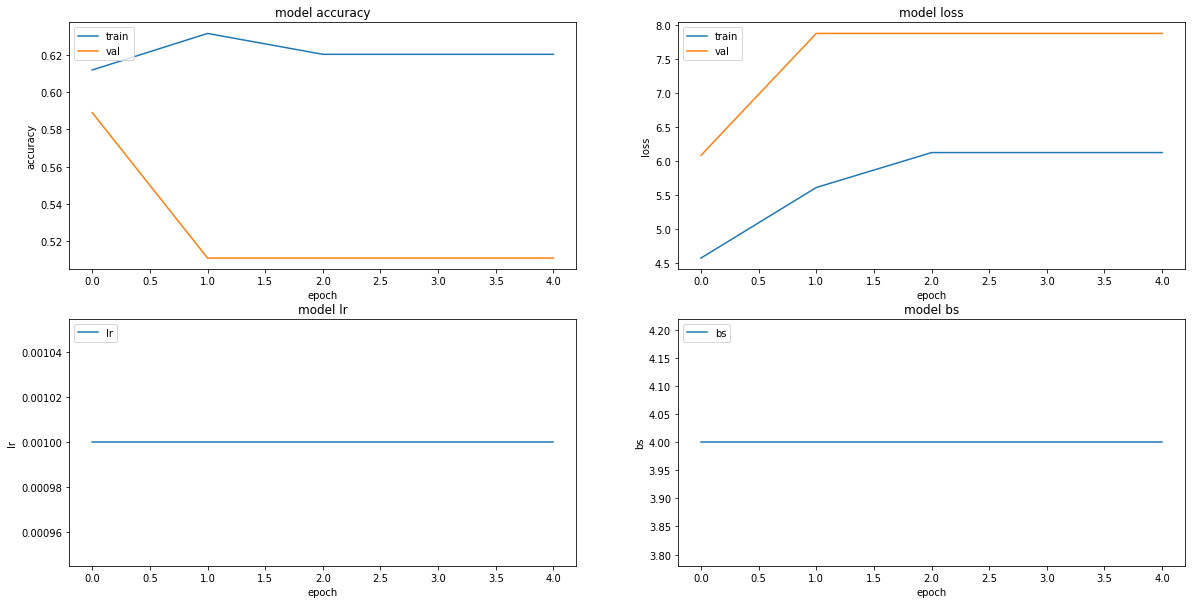

In [21]:
# plot dict values
plt.figure(figsize=(20,10))

# summarize history for accuracy
plt.subplot(2, 2, 1)
plt.plot(d['acc'])
plt.plot(d['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# summarize history for loss
plt.subplot(2, 2, 2)
plt.plot(d['loss'])
plt.plot(d['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# summarize history for lr
plt.subplot(2, 2, 3)
plt.plot(d['lr'])
plt.title('model lr')
plt.ylabel('lr')
plt.xlabel('epoch')
plt.legend(['lr'], loc='upper left')

# summarize history for bs
plt.subplot(2, 2, 4)
plt.plot(d['bs'])
plt.title('model bs')
plt.ylabel('bs')
plt.xlabel('epoch')
plt.legend(['bs'], loc='upper left')

plt.show()